In [114]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [115]:
Snow_sum1200_2015_2018=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/2015_2018__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)

# '/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/1987_1989__frequency_prop.csv' 
Snow_sum1200_2010_2014=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/2010_2014__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_2005_2009=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/2005_2009__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_2000_2004=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/2000_2004__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_2010_2018=pd.concat([Snow_sum1200_2010_2014, Snow_sum1200_2015_2018])
Snow_sum1200_2000_2009=pd.concat([Snow_sum1200_2000_2004, Snow_sum1200_2005_2009])

Snow_sum1200_1995_1999=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/1995_1999__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_1990_1994=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/1990_1994__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_1987_1989=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/1987_1989__frequency_prop.csv', usecols=[1, 2, 3, 4], index_col=0)
Snow_sum1200_1990_1999=pd.concat([Snow_sum1200_1990_1994, Snow_sum1200_1995_1999])
Snow_sum1200_1987_1989=pd.concat([Snow_sum1200_1987_1989])


In [116]:
Snow_sum1200_2010_2018.columns = ['snow_prop', 'pixel_prop', '1200_validpix_v_allpixels']
Snow_sum1200_2000_2009.columns = ['snow_prop', 'pixel_prop', '1200_validpix_v_allpixels']
Snow_sum1200_1990_1999.columns = ['snow_prop', 'pixel_prop', '1200_validpix_v_allpixels']
Snow_sum1200_1987_1989.columns = ['snow_prop', 'pixel_prop', '1200_validpix_v_allpixels']


In [7]:
# Snow_sum2010_2018.columns = ['snow_prop', 'pixel_prop', '1800_validpix_v_allpixels']

In [117]:
dfs_1200 = [(Snow_sum1200_2010_2018, 2010), (Snow_sum1200_2000_2009, 2000), (Snow_sum1200_1990_1999, 1990), (Snow_sum1200_1987_1989, 1980)]
# dfs_1800 = [(Snow_sum1800_2010_2018, 2010), (Snow_sum1800_2000_2009, 2000), (Snow_sum1800_1990_1999, 1990), (Snow_sum1800_1987_1989, 1980)]

In [118]:
for i, j in dfs_1200:
    i['20_50'] = np.where(i['snow_prop'] > 0.05, i['snow_prop'], np.nan)
    i['under_20%'] = np.where(i['1200_validpix_v_allpixels'] < 0.2, i['snow_prop'], np.nan)
    i['over_60%'] = np.where(i['1200_validpix_v_allpixels'] > 0.6, i['snow_prop'], np.nan)
#     i['50_70%'] = np.where(i['pixel_rel'] < 0.4, i['snow_prop_1800'], np.nan)
#     i['50_70%'] = np.where(i['pixel_rel'] < 0.4, np.nan, i['50_70%'])
#     i['30_50%'] = np.where(i['pixel_rel'] < 0.4, i['snow_prop_1800'], np.nan)
#     i['30_50%'] = np.where(i['pixel_rel'] < 0.3, np.nan, i['30_50%'])

# for i, j in dfs_1800:
#     i['20_50'] = np.where(i['snow_prop'] > 0.05, i['snow_prop'], np.nan)
#     i['under_20%'] = np.where(i['1800_validpix_v_allpixels'] < 0.2, i['snow_prop'], np.nan)
#     i['over_50%'] = np.where(i['1800_validpix_v_allpixels'] > 0.6, i['snow_prop'], np.nan)

In [73]:
#Snow_sum2010_2018

In [119]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
#lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2018-08-01', '2018-08-28')
resolution = (-25, 25)
landsat_goodquality_prop = 0.70
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)
elevation_query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
elevation_2d = elevation_data.dem_h.squeeze('time')
# contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
#                                             ds_array=elevation_2d,
#                                             ds_crs=elevation_2d.geobox.crs,
#                                             ds_affine=elevation_2d.geobox.affine,
#                                             output_shp='extracted_contours_1800.shp')
# contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500,
#                                             ds_array=elevation_2d,
#                                             ds_crs=elevation_2d.geobox.crs,
#                                             ds_affine=elevation_2d.geobox.affine,
#                                             output_shp='extracted_contours_1500.shp')
contour_gdf_1200 = SpatialTools.contour_extract(z_values=1200,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_tas_contours_1200.shp')

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 0 filtered ls7 timesteps
Loading ls8
    Loading 1 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Operating in single array, multiple z-values mode
    Extracting contour 1200
Exporting contour shapefile to extracted_tas_contours_1200.shp


In [64]:
# Snow_phen1800=pd.read_csv('phenology_1800_all.csv')
# Snow_phen1500=pd.read_csv('phenology_1500_all.csv')
# Snow_phen1200=pd.read_csv('phenology_1200_all.csv')

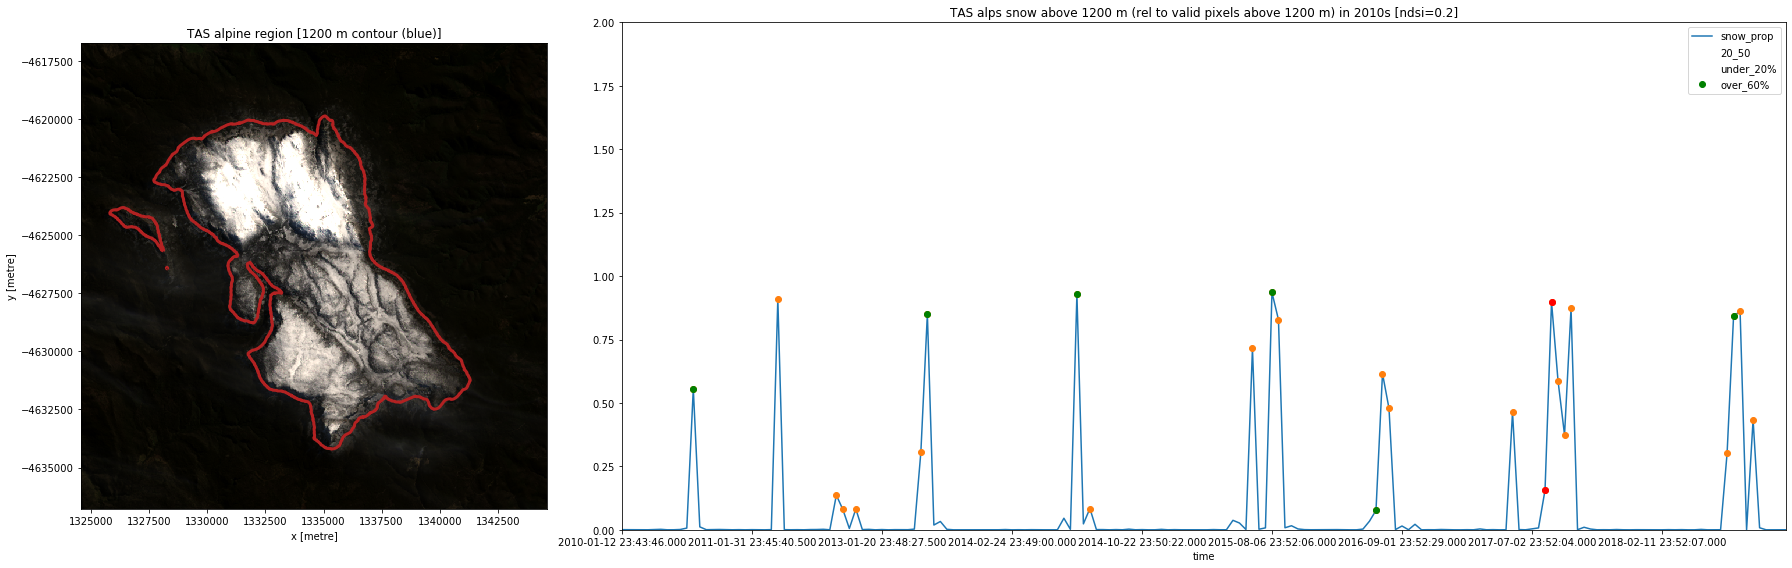

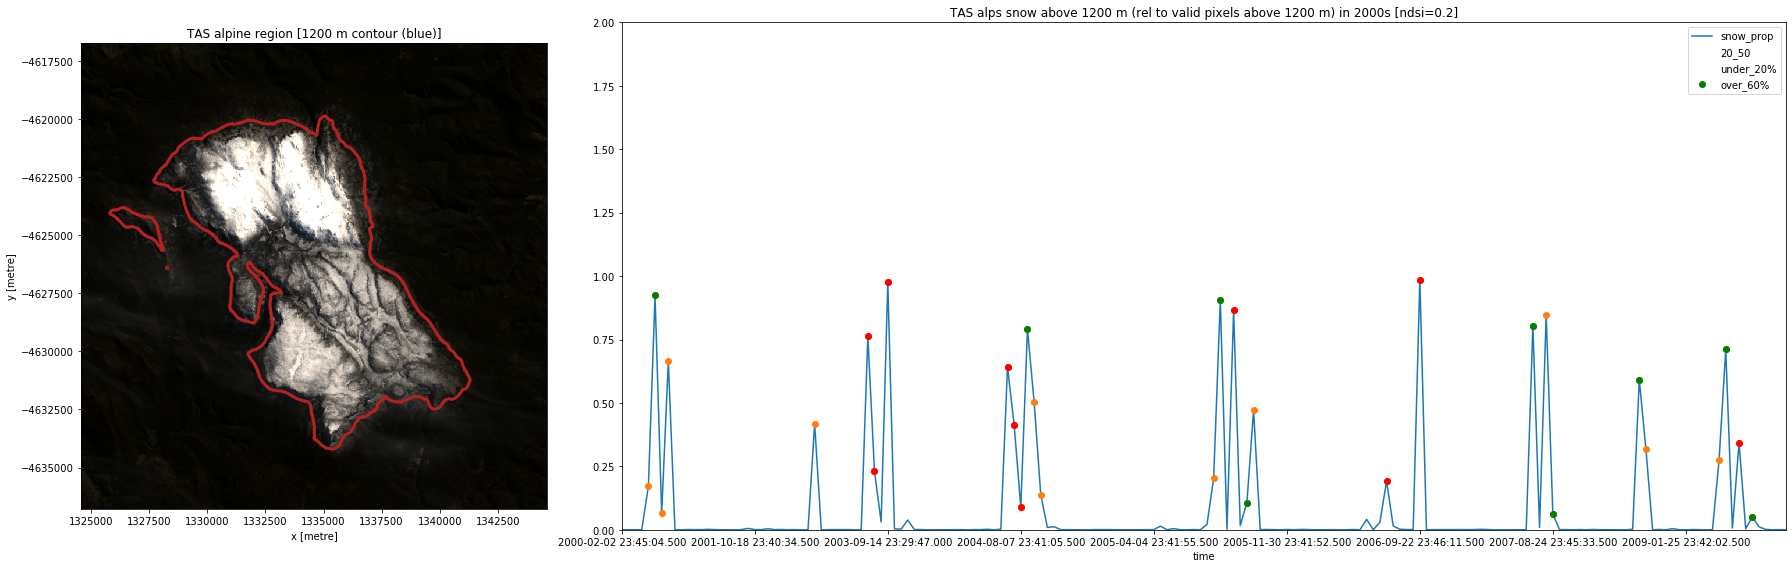

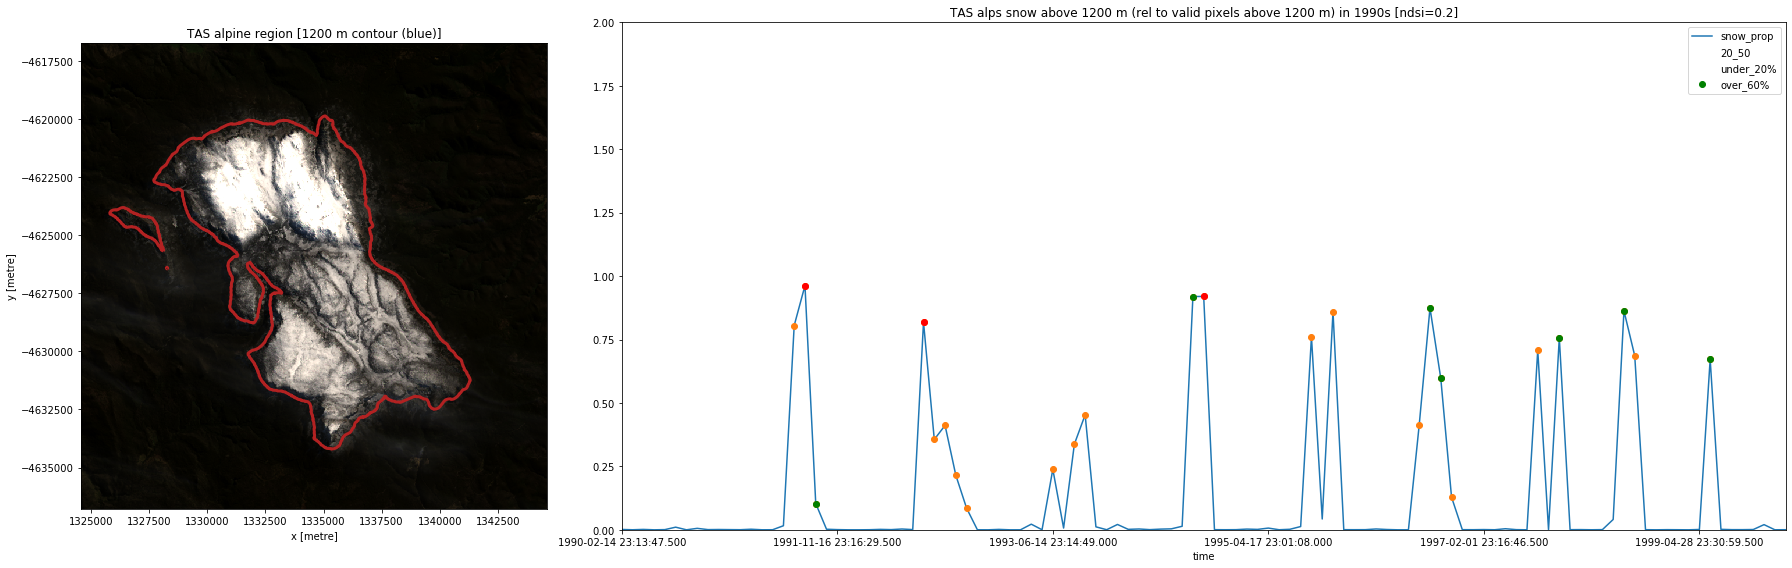

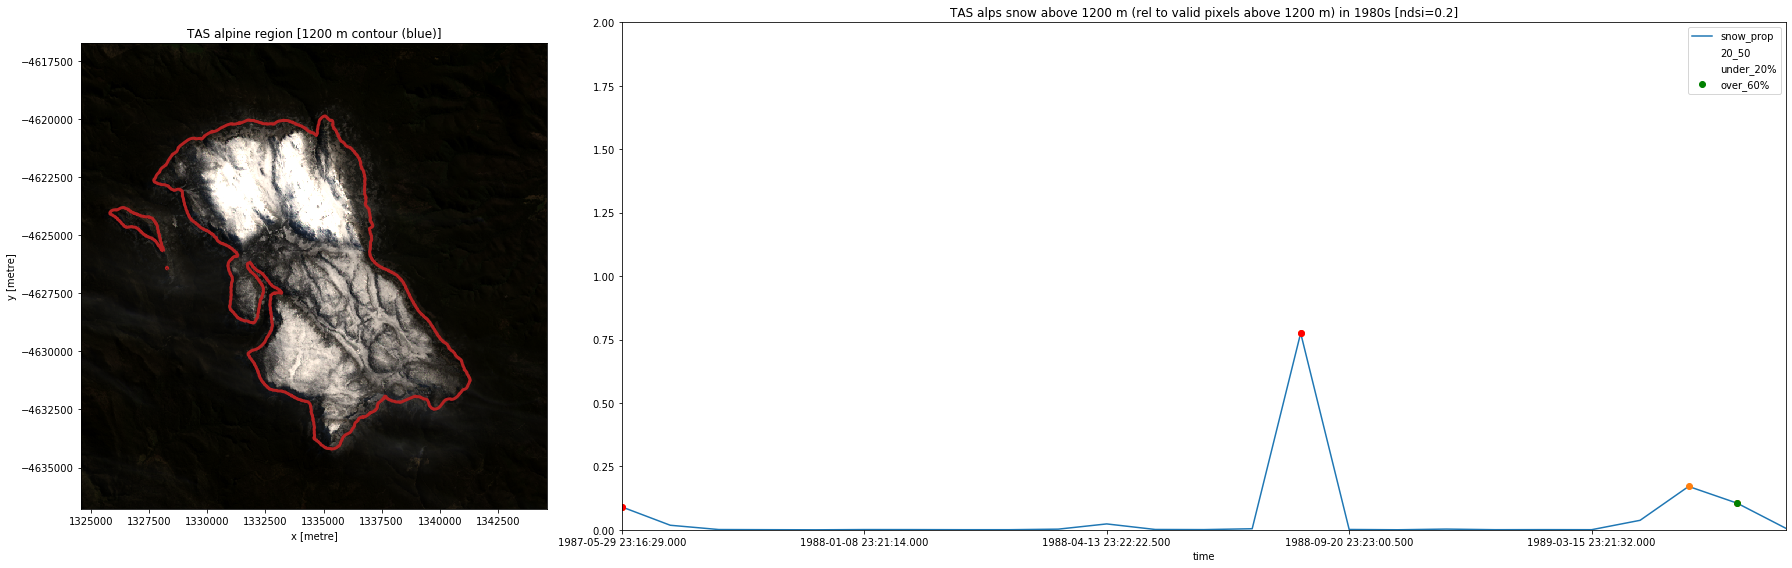

In [120]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("TAS_freq_cont_1200.pdf")

# dfs=[(Snow_phen1800, 1800), (Snow_phen1500, 1500), (Snow_phen1200, 1200)]
for i, j in dfs_1200:
    fig, axes = plt.subplots(ncols=2, 
                             figsize = (25, 8),
                            gridspec_kw={'width_ratios': [2, 5]})

#     fig, ax = plt.subplots(figsize=(20,8)) 
    b = i.plot(y='snow_prop', ylim=(0,2),ax=axes[1], title='TAS alps snow above 1200 m (rel to valid pixels above 1200 m) in '+str(j)+'s [ndsi=0.2]')
    b = i.plot(y='20_50',style='o', ax=axes[1])
    b = i.plot(y='under_20%',style='ro', ax=axes[1])
    b = i.plot(y='over_60%', style='go', ax=axes[1])



    a=landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=0, color='mediumblue')
#     a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='orange')
    a=contour_gdf_1200.plot(ax=axes[0], linewidth=3, color='firebrick')
    a.title.set_text('TAS alpine region [1200 m contour (blue)]')
    plt.tight_layout()

#     sp = plt.scatter(Snow_phen1800['dayofyear'], #ndsi_ds.values, 
#                     Snow_phen1800['average_ndsi'], c=Snow_phen1800['year'],
#                     cmap='jet', marker='o', edgecolor='none',s=35)
#     plt.ylim(-1, 1)
#     plt.title('Snow Phenology above 1800 m (1987-2018)')
#     plt.xlabel('Days of the year')
#     plt.ylabel('ave NDSI for valid pixels over 1800m')
#     fig.colorbar(sp)
    pdf.savefig()
pdf.close()

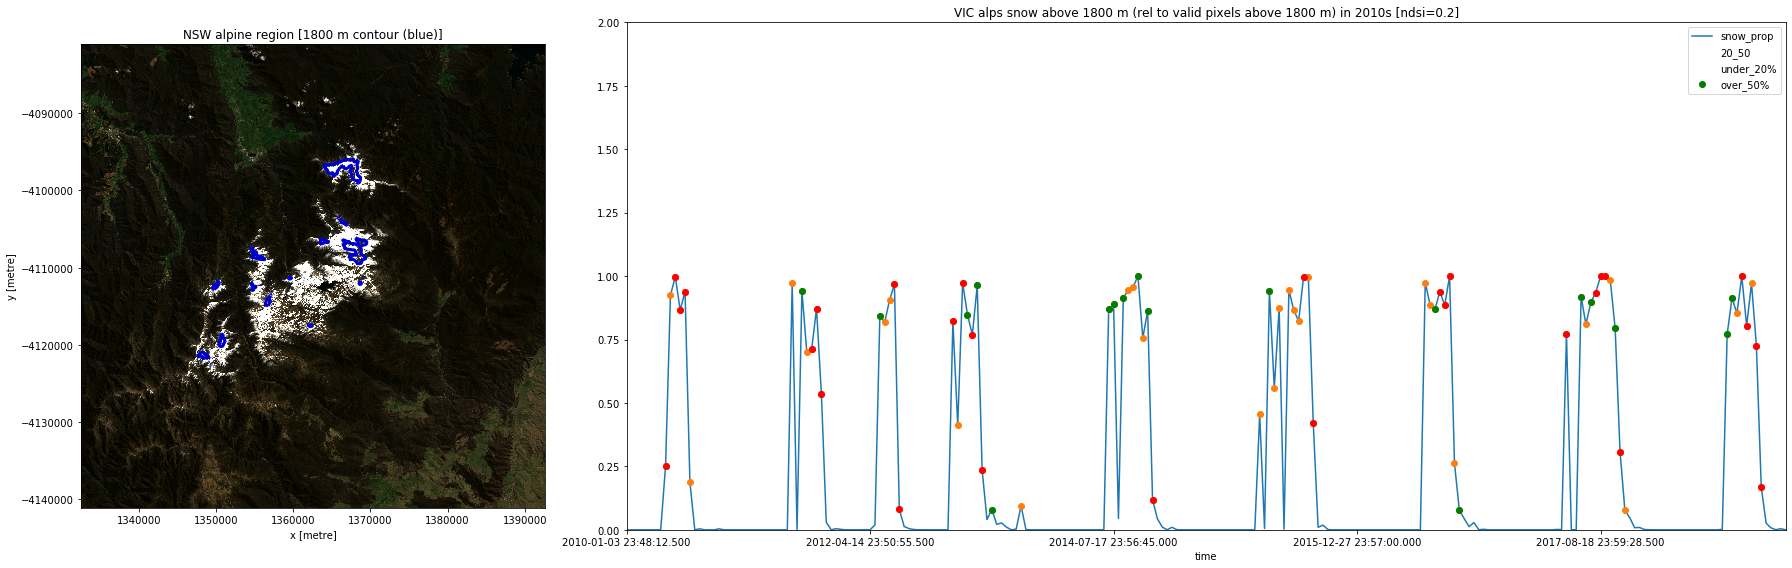

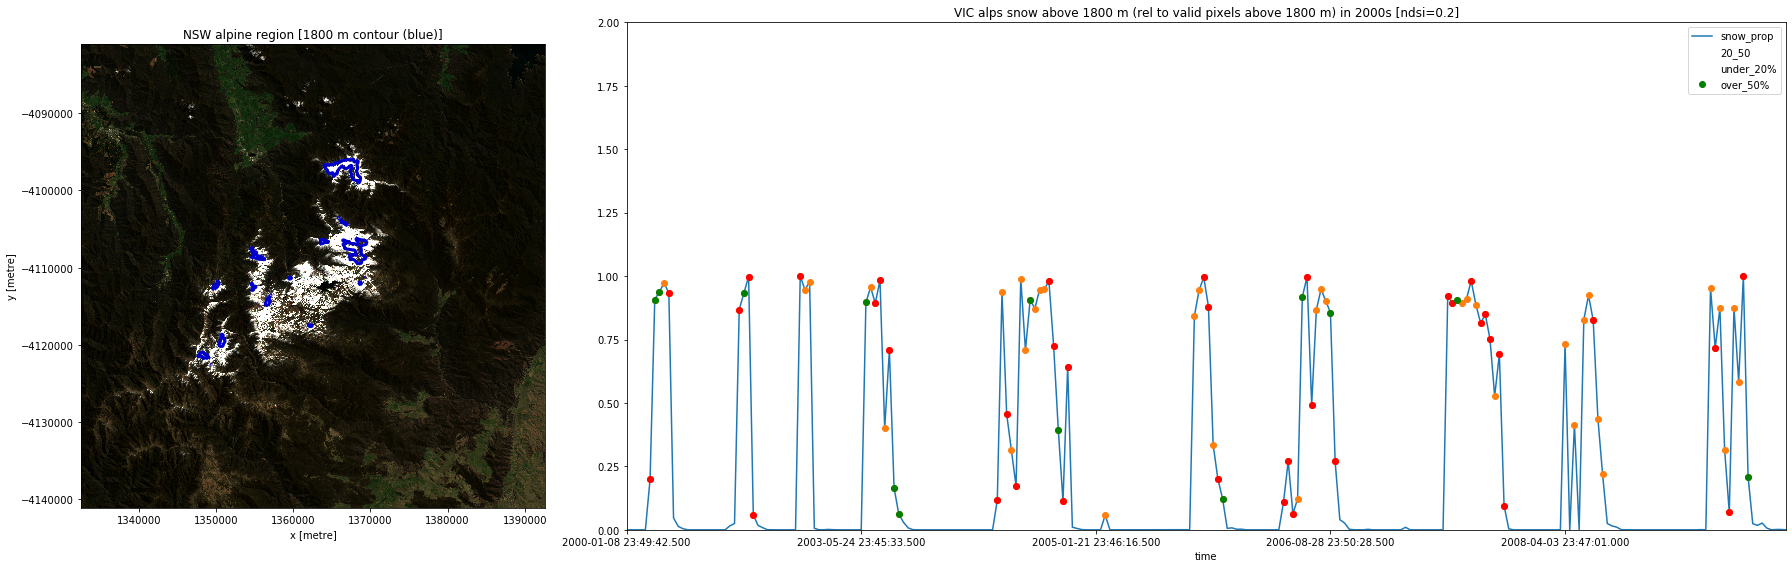

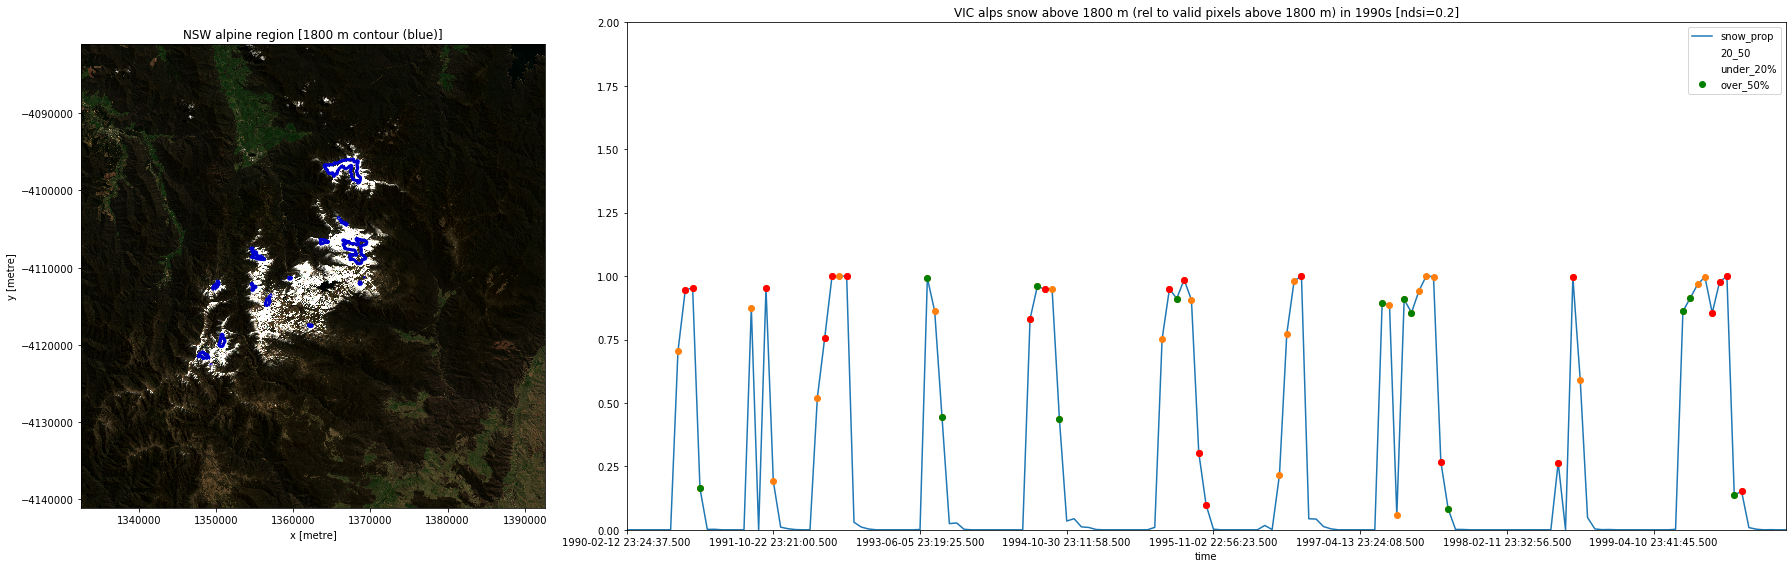

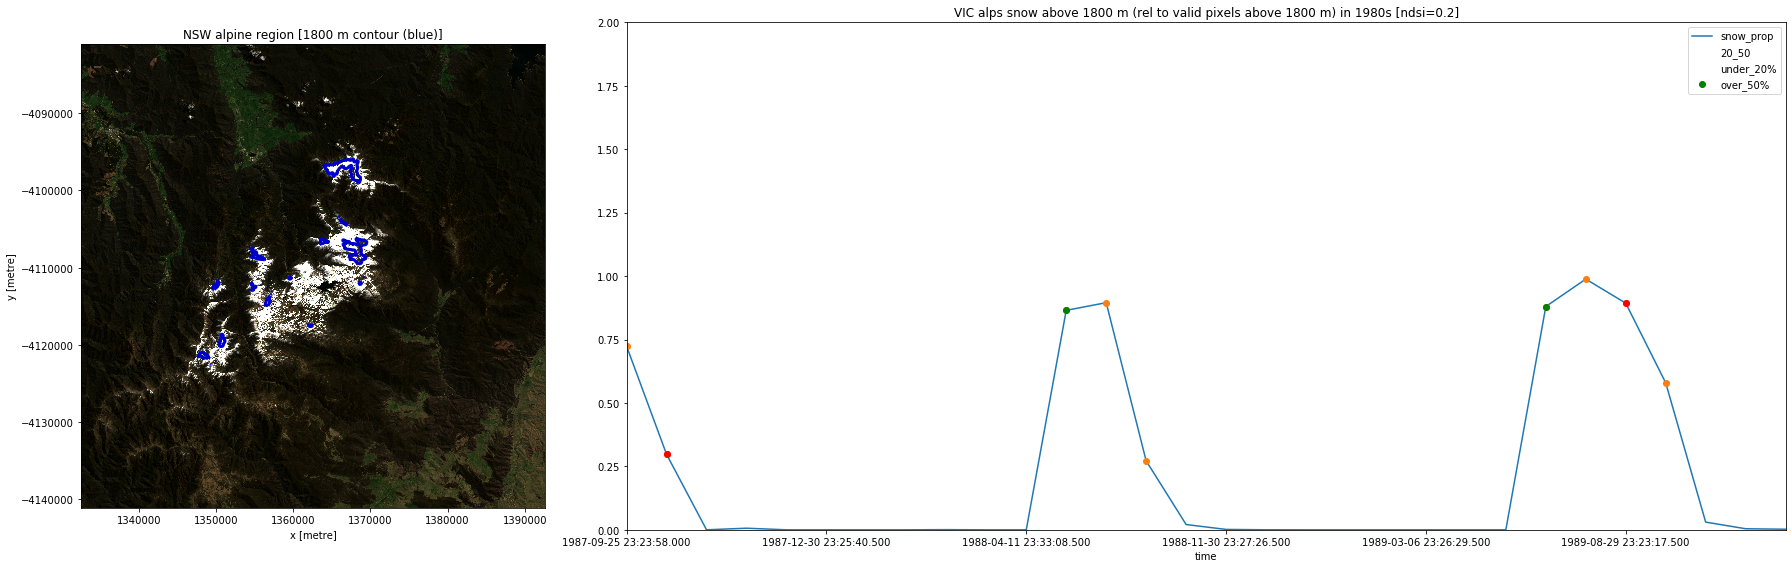

In [90]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("VIC_freq_cont_1800.pdf")

# dfs=[(Snow_phen1800, 1800), (Snow_phen1500, 1500), (Snow_phen1200, 1200)]
for i, j in dfs_1800:
    fig, axes = plt.subplots(ncols=2, 
                             figsize = (25, 8),
                            gridspec_kw={'width_ratios': [2, 5]})

#     fig, ax = plt.subplots(figsize=(20,8)) 
    b = i.plot(y='snow_prop', ylim=(0,2),ax=axes[1], title='VIC alps snow above 1800 m (rel to valid pixels above 1800 m) in '+str(j)+'s [ndsi=0.2]')
    b = i.plot(y='20_50',style='o', ax=axes[1])
    b = i.plot(y='under_20%',style='ro', ax=axes[1])
    b = i.plot(y='over_50%', style='go', ax=axes[1])



    a=landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=axes[0],robust=True)
    a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='mediumblue')
    a=contour_gdf_1500.plot(ax=axes[0], linewidth=0, color='orange')
    a=contour_gdf_1200.plot(ax=axes[0], linewidth=0, color='firebrick')
    a.title.set_text('NSW alpine region [1800 m contour (blue)]')
    plt.tight_layout()

#     sp = plt.scatter(Snow_phen1800['dayofyear'], #ndsi_ds.values, 
#                     Snow_phen1800['average_ndsi'], c=Snow_phen1800['year'],
#                     cmap='jet', marker='o', edgecolor='none',s=35)
#     plt.ylim(-1, 1)
#     plt.title('Snow Phenology above 1800 m (1987-2018)')
#     plt.xlabel('Days of the year')
#     plt.ylabel('ave NDSI for valid pixels over 1800m')
#     fig.colorbar(sp)
    pdf.savefig()
pdf.close()

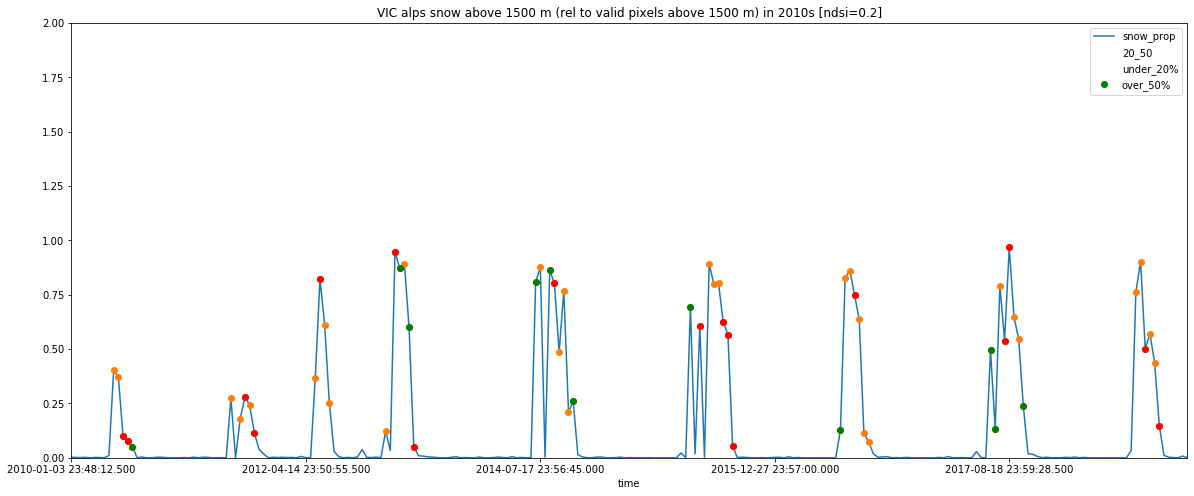

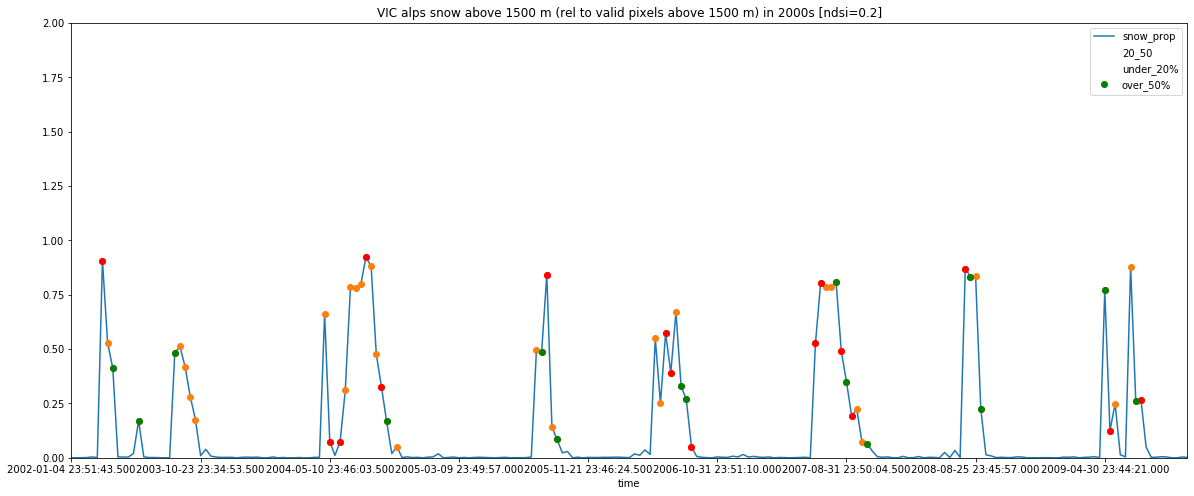

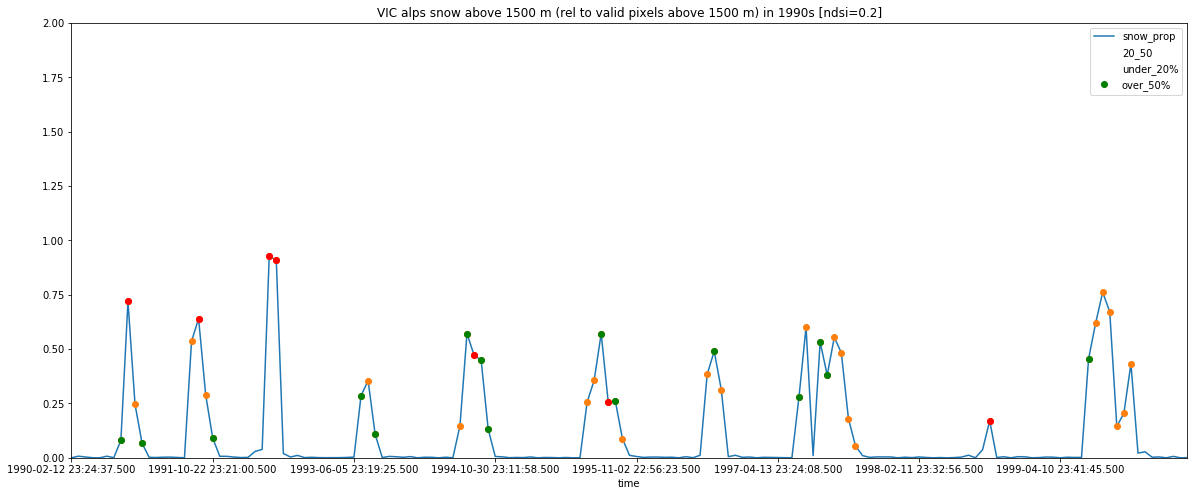

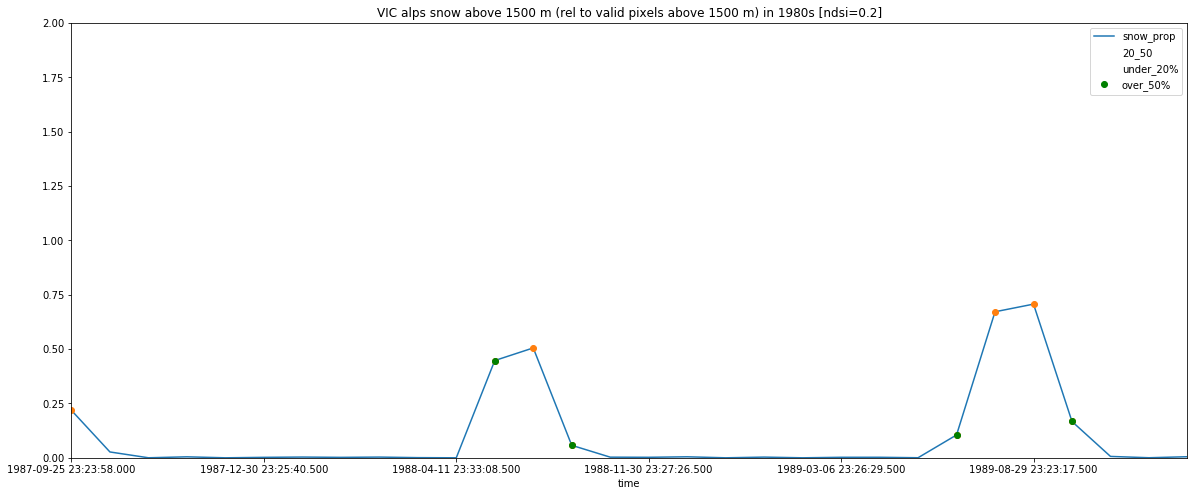

In [40]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("nbar_acca_snow_frequency_VIC.pdf")
years = mdates.YearLocator()
months = mdates.MonthLocator() 
years_fmt = mdates.DateFormatter('%Y')

for i,j in dfs:
    fig, ax = plt.subplots(figsize=(20,8)) 
    b = i.plot(y='snow_prop', ylim=(0,2),ax=ax, title='VIC alps snow above 1500 m (rel to valid pixels above 1500 m) in '+str(j)+'s [ndsi=0.2]')
    b = i.plot(y='20_50',style='o', ax=ax)
    
    b = i.plot(y='under_20%',style='ro', ax=ax)
    b = i.plot(y='over_50%', style='go', ax=ax)
   
 
#     b.xaxis.set_major_formatter(years_fmt)
#     b.xaxis.set_minor_locator(months)
    
# #     b.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     b.xaxis.set_ticks( i.index[:-4], minor=True)
#     b.tick_params(axis='x', which='minor', direction='in', pad=-10)
    #plt.xticks[:-10]
    #plt.xticks(rotation=65)
    
#     b.xaxis.set_major_locator(mdates.YearLocator())
#     b.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    pdf.savefig()
pdf.close()

In [ ]:
for i, j in dfs:
    i['30_70'] = np.where(i['snow_prop'] > 0.05, i['snow_prop'], np.nan)
    i['under_30%'] = np.where(i['1800_validpix_v_allpixels'] < 0.3, i['snow_prop'], np.nan)
    i['over_70%'] = np.where(i['1800_validpix_v_allpixels'] > 0.7, i['snow_prop'], np.nan)
    i['50_70%'] = np.where(i['1800_validpix_v_allpixels'] < 0.7, i['snow_prop'], np.nan)
    i['50_70%'] = np.where(i['1800_validpix_v_allpixels'] < 0.5, np.nan, i['50_70%'])
    i['30_50%'] = np.where(i['1800_validpix_v_allpixels'] < 0.5, i['snow_prop'], np.nan)
    i['30_50%'] = np.where(i['1800_validpix_v_allpixels'] < 0.3, np.nan, i['30_50%'])

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("snow_frequency_NSW.pdf")
year = [2010, 2000, 1990, 1980]
for i,j in dfs:
    fig, ax = plt.subplots(figsize=(18,8)) 
    b = i.plot(y='snow_prop', ylim=(0,1),ax=ax, title='snow (prop of valid pixels) in '+str(j)+'s [ndsi=0.2]')
    b = i.plot(y='under_30%',style='ro', ax=ax)
    b = i.plot(y='30_50%',style='o', ax=ax)
    b = i.plot(y='50_70%',style='bo', ax=ax)
    b = i.plot(y='over_70%', style='go', ax=ax)
    pdf.savefig()
pdf.close()